In [1]:
import numpy as np
from scipy.spatial.distance import euclidean
import scipy
import torch

import dtw
from fastdtw import fastdtw

from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector, StochasticSiameseLSTMNet

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

%matplotlib inline

## Load data

In [2]:
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left',
                'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']

wanted_words_combined = wanted_words

model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.04,
    'winstep': 0.04
}

In [3]:
preproc = AudioPreprocessorFbank(nfilt=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

In [4]:
n_mini_batch_size = 1
data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])

(1, 24, 26)


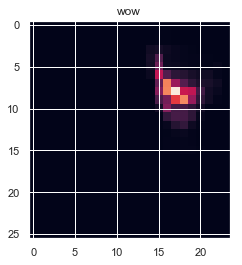

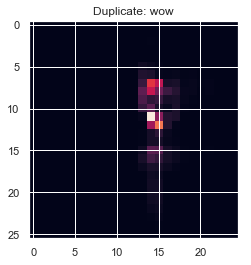

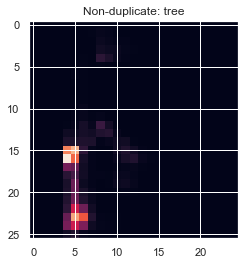

In [5]:
print(data['x'].shape)
plt.figure()
plt.imshow(data['x'].squeeze().T)
label = index_to_word[labels[0]]
plt.title(f'{label}')

plt.figure()
plt.imshow(duplicates['x'].squeeze().T)
label = index_to_word[labels[0]]
plt.title(f'Duplicate: {label}')

plt.figure()
plt.imshow(non_duplicates['x'].squeeze().T)
non_duplicate_label = index_to_word[non_duplicates['y'][0]]
plt.title(f'Non-duplicate: {non_duplicate_label}')
plt.show()

duplicates optimal path
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23)]
duplicates optimal path
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 8), (10, 8), (11, 9), (12, 10), (13, 11), (14, 12), (15, 13), (16, 14), (17, 15), (17, 16), (17, 17), (18, 18), (19, 19), (20, 20), (20, 21), (21, 22), (22, 23), (23, 24)]
non-duplicates optimal path
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (15, 4), (16, 5), (17, 6), (18, 7), (19, 8), (20, 9), (21, 10), (22, 11), (23, 12), (23, 13), (23, 14), (23, 15), (23, 16), (23, 17), (23, 18), (23, 19), (23, 20), (23, 21), (23, 22), (23, 23), (23, 24)]


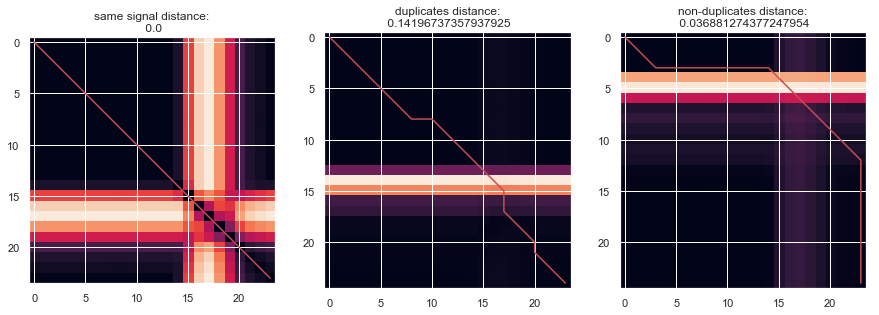

In [6]:
x = data['x'].squeeze()


fig, axes = plt.subplots(1, 3, figsize=(15,5))


# same thing dtw]

y = data['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

axes[0].imshow(res[1].T)
axes[0].plot(res[3][0], res[3][1], color='r')
axes[0].title.set_text(f'same signal distance:\n {res[0]}')
print('duplicates optimal path')
print(list(zip(*res[3])))

# duplicates dtw

y = duplicates['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[1].imshow(res[1].T)
axes[1].plot(res[3][0], res[3][1], color='r')
axes[1].title.set_text(f'duplicates distance:\n {res[0]}')
print('duplicates optimal path')
print(list(zip(*res[3])))


# non-duplicates dtw

y = non_duplicates['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[2].imshow(res[1].T)
axes[2].plot(res[3][0], res[3][1], color='r')
axes[2].title.set_text(f'non-duplicates distance:\n {res[0]}')
print('non-duplicates optimal path')
print(list(zip(*res[3])))

duplicates optimal path
duplicates optimal path
non-duplicates optimal path


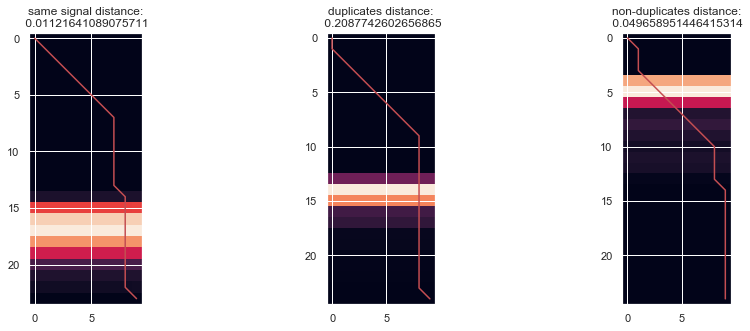

In [7]:
x = data['x'].squeeze()[:10]


fig, axes = plt.subplots(1, 3, figsize=(15,5))


# self dtw (extpected to be 0)

y = data['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

axes[0].imshow(res[1].T)
axes[0].plot(res[3][0], res[3][1], color='r')
axes[0].title.set_text(f'same signal distance:\n {res[0]}')
print('duplicates optimal path')
# print(list(zip(*res[3])))

# duplicates dtw

y = duplicates['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[1].imshow(res[1].T)
axes[1].plot(res[3][0], res[3][1], color='r')
axes[1].title.set_text(f'duplicates distance:\n {res[0]}')
print('duplicates optimal path')
# print(list(zip(*res[3])))


# non-duplicates dtw

y = non_duplicates['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[2].imshow(res[1].T)
axes[2].plot(res[3][0], res[3][1], color='r')
axes[2].title.set_text(f'non-duplicates distance:\n {res[0]}')
print('non-duplicates optimal path')
# print(list(zip(*res[3])))

# Gather Data for analysis

In [8]:
n_mini_batch_size = 1000

# gather data


data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])


## DTW distribution on raw data

In [ ]:

# initialize dist_lists

duplicates_dtw = []
non_duplicates_dtw = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = data['x'][i].squeeze()
    
    y_duplicate = duplicates['x'][i].squeeze()
    duplicates_dtw.append(dtw.dtw(x, y_duplicate, dist=euclidean)[0])

    y_non_duplicate = non_duplicates['x'][i].squeeze()
    non_duplicates_dtw.append(dtw.dtw(x, y_non_duplicate, dist=euclidean)[0])    

517

In [ ]:
bins = np.linspace(0, 1., 200)
fig, axes = plt.subplots(2, 1, figsize=(15,10))

duplicates_dtw_filtered = np.array(duplicates_dtw)[np.where(np.array(duplicates_dtw) < 1.)]
non_duplicates_dtw_filtered = np.array(non_duplicates_dtw)[np.where(np.array(non_duplicates_dtw) < 1.)]


sns.distplot(duplicates_dtw_filtered, bins=bins, ax=axes[0], kde=False)
axes[0].title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_filtered, bins=bins, color='y', ax=axes[1], kde=False)
axes[1].title.set_text('non-duplicates DTW')
plt.show()

### KL Divergence between two DTW distributions:

In [ ]:
hist_dup, _ = np.histogram(duplicates_dtw, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")


### As it can be seen, DTW calculated on MFCCs signals failed to capture different and similar samples showing no significant difference between duplicates and non-duplicates pairs. Kullback-Leibler divergence just proves this fact that P (distribution of distances between duplicate samples) and Q (non-duplicate ones) have no significant difference.

# Improving DTW using latent variables from LSTM classifier as a signal

In [538]:
# load nn

nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/stochastic_seamise_net_09_16_2019_03_08_PM/net_0.8671875.net'
nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/stochastic_seamise_net_09_14_2019_09_18_PM/net_0.94921875.net'

nn = torch.load(nn_fname)

In [539]:
nn_input = torch.from_numpy(data['x']).cuda().float()

In [540]:
z0, _, z, _ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

z0, _, duplicates_z, _ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

z0, _, non_duplicates_z, _ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

In [541]:
# random latent variables
# z, _, _, _ = nn.single_forward(nn_input)
# z = z.detach().cpu().numpy()

# duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
# duplicates_z = duplicates_z.detach().cpu().numpy()

# non_duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
# non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

duplicates optimal path
duplicates optimal path
non-duplicates optimal path


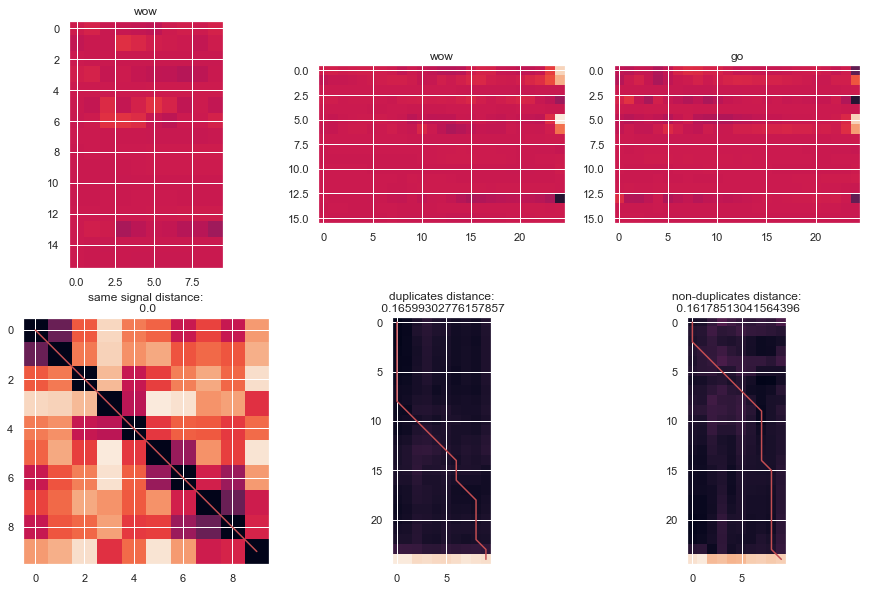

In [559]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(z[i].T, vmin=-1, vmax=1)
# fig.colorbar(im)
label = index_to_word[data['y'][i]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[data['y'][i]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][i]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = z[sample_idx]

# self dtw (extpected to be 0)

y = z[sample_idx]
res = dtw.dtw(x, y, dist=euclidean)

axes[1][0].imshow(res[1].T)
axes[1][0].plot(res[3][0], res[3][1], color='r')
axes[1][0].title.set_text(f'same signal distance:\n {res[0]}')
print('duplicates optimal path')
# print(list(zip(*res[3])))

# duplicates dtw

y = duplicates_z[sample_idx]
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[1][1].imshow(res[1].T)
axes[1][1].plot(res[3][0], res[3][1], color='r')
axes[1][1].title.set_text(f'duplicates distance:\n {res[0]}')
print('duplicates optimal path')
# print(list(zip(*res[3])))


# non-duplicates dtw

y = non_duplicates_z[sample_idx]
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[1][2].imshow(res[1].T)
axes[1][2].plot(res[3][0], res[3][1], color='r')
axes[1][2].title.set_text(f'non-duplicates distance:\n {res[0]}')
print('non-duplicates optimal path')
# print(list(zip(*res[3])))

# DTW distribution in latent space z

In [543]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtw.dtw(x, y_duplicate, dist=euclidean)[0])

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtw.dtw(x, y_non_duplicate, dist=euclidean)[0])    

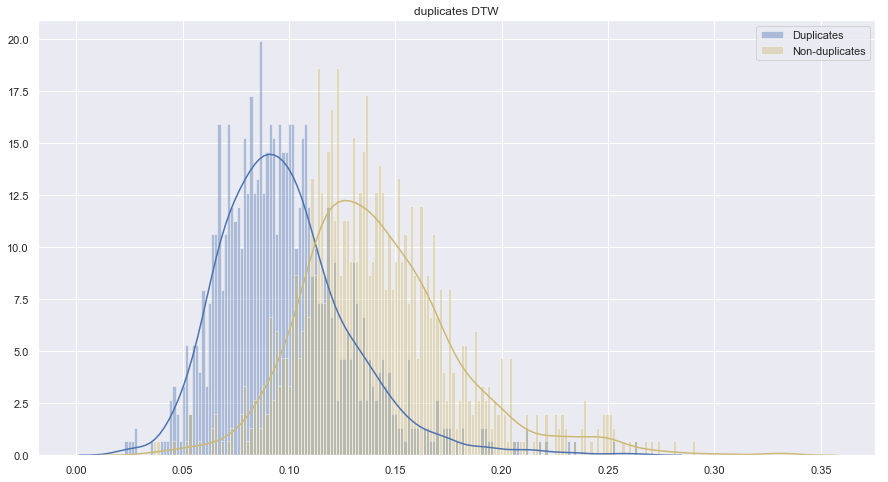

DKL is: 1.7066


In [544]:
bins = np.linspace(0, 0.3, 200)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Duplicates")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Non-duplicates')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")

## Disctance between very last frames of samples

In [545]:

# initialize dist_lists

duplicates_last_dtw_z = []
non_duplicates_last_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i][-1, :].squeeze()
    
    y_duplicate = duplicates_z[i][-1, :].squeeze()
    duplicates_last_dtw_z.append(dtw.dtw(x, y_duplicate, dist=euclidean)[0])

    y_non_duplicate = non_duplicates_z[i][-1, :].squeeze()
    non_duplicates_last_dtw_z.append(dtw.dtw(x, y_non_duplicate, dist=euclidean)[0])    


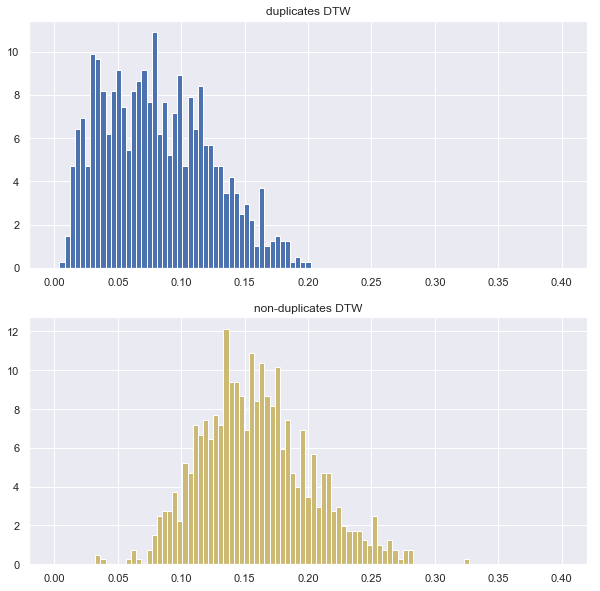

DKL is: 3.0261


In [546]:

bins = np.linspace(0, 0.4, 100)
fig, axes = plt.subplots(2, 1, figsize=(10,10))

axes[0].hist(duplicates_last_dtw_z, bins=bins,density=True)
axes[0].title.set_text('duplicates DTW')

axes[1].hist(non_duplicates_last_dtw_z, bins=bins, color='y', density=True)
axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_last_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_last_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")


# 2. DTW (prefix case n << m, n = 10)

In [560]:
PREFIX_LEN = 10

## DTW distribution on raw data

In [561]:

# initialize dist_lists
data_shorten = {}
data_shorten['x'] = data['x'][:, :PREFIX_LEN, :]

duplicates_dtw = []
non_duplicates_dtw = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = data_shorten['x'][i].squeeze()
    
    y_duplicate = duplicates['x'][i, :PREFIX_LEN, :].squeeze()
    duplicates_dtw.append(dtw.dtw(x, y_duplicate, dist=euclidean)[0])

    y_non_duplicate = non_duplicates['x'][i, :PREFIX_LEN, :].squeeze()
    non_duplicates_dtw.append(dtw.dtw(x, y_non_duplicate, dist=euclidean)[0])    

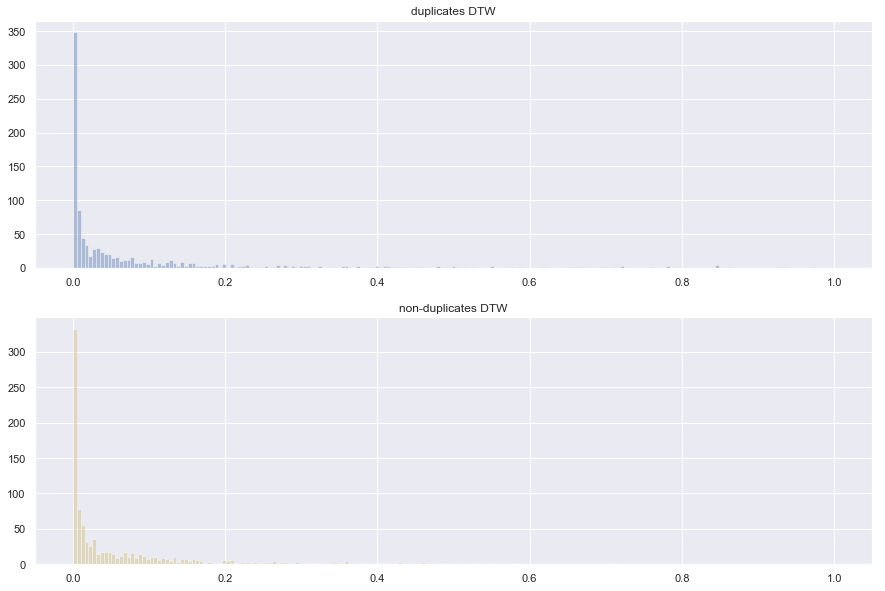

In [562]:
bins = np.linspace(0, 1., 200)
fig, axes = plt.subplots(2, 1, figsize=(15,10))

duplicates_dtw_filtered = np.array(duplicates_dtw)[np.where(np.array(duplicates_dtw) < 1.)]
non_duplicates_dtw_filtered = np.array(non_duplicates_dtw)[np.where(np.array(non_duplicates_dtw) < 1.)]


sns.distplot(duplicates_dtw_filtered, bins=bins, ax=axes[0], kde=False)
axes[0].title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_filtered, bins=bins, color='y', ax=axes[1], kde=False)
axes[1].title.set_text('non-duplicates DTW')
plt.show()

### KL Divergence between two DTW distributions:

In [563]:
hist_dup, _ = np.histogram(duplicates_dtw, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")


DKL is: 0.2631


# Improving DTW using latent variables from LSTM classifier as a signal

In [564]:
nn_input = torch.from_numpy(data_shorten['x']).cuda().float()

In [565]:
z0, _, z, _ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

z0, _, duplicates_z, _ = nn.single_forward(torch.from_numpy(duplicates['x'][:, :PREFIX_LEN, :]).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

z0, _, non_duplicates_z, _ = nn.single_forward(torch.from_numpy(non_duplicates['x'][:, :PREFIX_LEN, :]).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

In [566]:
# random latent variables
# z, _, _, _ = nn.single_forward(nn_input)
# z = z.detach().cpu().numpy()

# duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
# duplicates_z = duplicates_z.detach().cpu().numpy()

# non_duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
# non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

duplicates optimal path
duplicates optimal path
non-duplicates optimal path


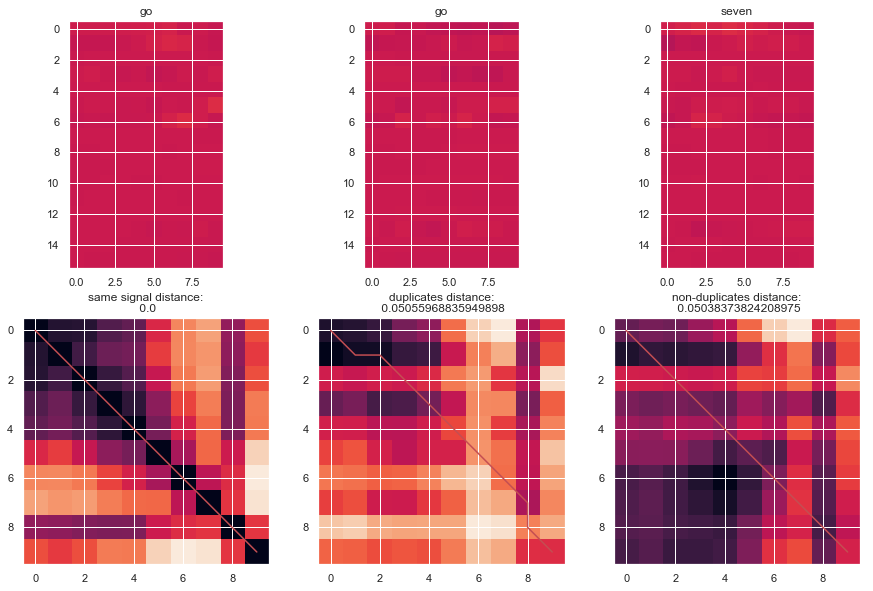

In [567]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(z[i].T, vmin=-1, vmax=1)
# fig.colorbar(im)
label = index_to_word[data['y'][i]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[data['y'][i]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][i]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = z[sample_idx]

# self dtw (extpected to be 0)

y = z[sample_idx]
res = dtw.dtw(x, y, dist=euclidean)

axes[1][0].imshow(res[1].T)
axes[1][0].plot(res[3][0], res[3][1], color='r')
axes[1][0].title.set_text(f'same signal distance:\n {res[0]}')
print('duplicates optimal path')
# print(list(zip(*res[3])))

# duplicates dtw

y = duplicates_z[sample_idx]
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[1][1].imshow(res[1].T)
axes[1][1].plot(res[3][0], res[3][1], color='r')
axes[1][1].title.set_text(f'duplicates distance:\n {res[0]}')
print('duplicates optimal path')
# print(list(zip(*res[3])))


# non-duplicates dtw

y = non_duplicates_z[sample_idx]
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[1][2].imshow(res[1].T)
axes[1][2].plot(res[3][0], res[3][1], color='r')
axes[1][2].title.set_text(f'non-duplicates distance:\n {res[0]}')
print('non-duplicates optimal path')
# print(list(zip(*res[3])))

# DTW distribution in latent space z

In [568]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtw.dtw(x, y_duplicate, dist=euclidean)[0])

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtw.dtw(x, y_non_duplicate, dist=euclidean)[0])    

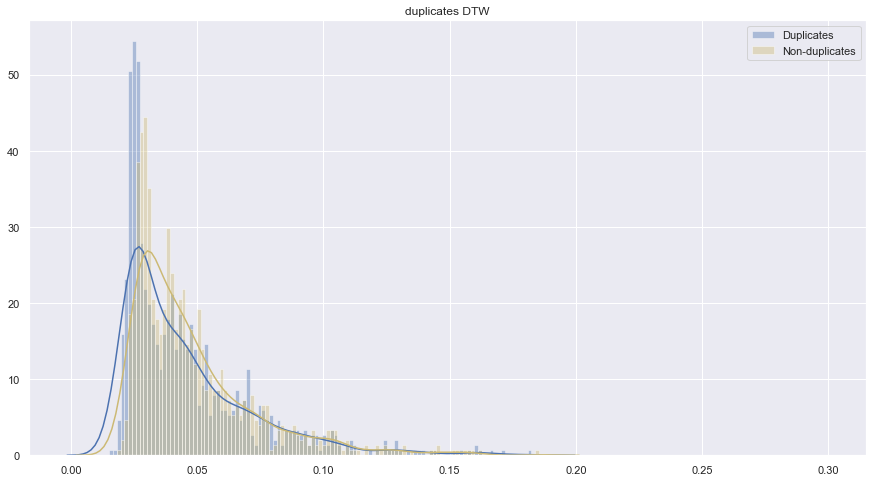

DKL is: 0.2675


In [569]:
bins = np.linspace(0, 0.3, 200)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Duplicates")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Non-duplicates')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")

## Disctance between very last frames of samples

In [570]:

# initialize dist_lists

duplicates_last_dtw_z = []
non_duplicates_last_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i][-1, :].squeeze()
    
    y_duplicate = duplicates_z[i][-1, :].squeeze()
    duplicates_last_dtw_z.append(dtw.dtw(x, y_duplicate, dist=euclidean)[0])

    y_non_duplicate = non_duplicates_z[i][-1, :].squeeze()
    non_duplicates_last_dtw_z.append(dtw.dtw(x, y_non_duplicate, dist=euclidean)[0])    


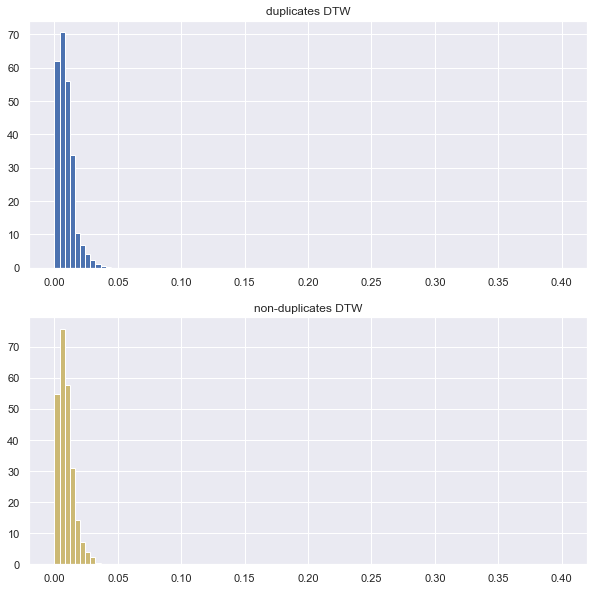

DKL is: 0.0152


In [571]:

bins = np.linspace(0, 0.4, 100)
fig, axes = plt.subplots(2, 1, figsize=(10,10))

axes[0].hist(duplicates_last_dtw_z, bins=bins,density=True)
axes[0].title.set_text('duplicates DTW')

axes[1].hist(non_duplicates_last_dtw_z, bins=bins, color='y', density=True)
axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_last_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_last_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")
